In [ ]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path):
    
    
    Area=pi*spotsize**2

    
    selector= sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


#     print ( f'IP-laser spot size: {spotsize:.2f} micron')
#     print ( f'baseline          : {baseline/1e6:.2f} metres')
#     print ('-'*42)

#     print (f'photons in spot')
#     print (f'macrophoton weight               : {amax(W):.4g}')
    
#     print ( 'macrophotons, finite source size :',sum( selector) )
    
#     print ( 'photon weight, finite source size:',sum(W[selector ] ) )
    
    
    P=sum(W[selector ] )/Area
    
#     print ( f'Photon density, finite source size:',P)
    
#     print (' ######################################### '  )
#     print ('                           '  )
#     plt.figure(figsize=(14,6))

    

#     ax1=plt.subplot(122,aspect=1)

#     # plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);





#     plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

#     plt.xlim(-2*spotsize,2*spotsize)
#     plt.ylim(-2*spotsize,2*spotsize)
    
#     plt.xlabel(r'$x$ (micron)')
#     plt.ylabel(r'$y$ (micron)');
#     plt.title(f'Finite source size, Photon density:{round(P,2)} micron^(-2)')

    
#     ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


#     plt.suptitle(f' sigmaT :{sigmaT} micron ; spotsize:{spotsize} micron')
#     plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)
    
    return(P)
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(input_filename + '.h5' ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( input_filename + '.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        mode             = input_dict['control']['mode']


        beam_charge      = float( input_dict['beam']['beam_charge'])
        number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
        sampling = mode

        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        gamma            = float(input_dict['beam']['gamma'])
        Xr               = 4*gamma*omega0/511*10**(-3)
        energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])
#     print (f'beam charge                              : {beam_charge*1e12:.24} pC')
#     print (f'number of beam electrons                 : {number_electrons:.3e}')
#     print ('-'*42)
#     print (f'{sampling} sampling:')
#     print (f'max  single photon weight                : {amax(W):.4g}')
#     print (f'mean single photon weight                : {mean(W):.4g}')
#     print (f'total photon weight                      : {sum(W):.4g}')
#     print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
#     print (f'total macro photon number                : {len(W)}')
#     print ('-'*42)
#     print(f' Frequency (Laser) :  {omega0}'  )
#     print(f'Recoil Factor:{Xr}')
#     print (' ######################################### '  )
#     print ('                           '  )
    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path)
    
    
    
    
    return(Pd)

In [13]:


input_filename = "New"
n=10
sigma=zeros(n)
r=2 #Number of runs
Pd = ones((n,2,r))
spotsize1=3
spotsize2=10
directory = "Sigma_W0_Run1"
parent_dir = f"{os. getcwd()}\Photon_Density"
path = os.path.join(parent_dir, directory)
os.mkdir(path)
for j in range(r):
    for i in range(n):
        with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            sigma1= 5+i*5

            input_dict['beam']['sigmaT']=sigma1
            input_dict['control']['name']=f'{path}\SigmaT{sigma1}'
            input_dict['laser']['w0']=sigma1
            ###Comment the previous line to just to do a parameter run in sigmaT
            input_filename1 = f'SigmaT{sigma1}'


        with open(      f'{path}\SigmaT{sigma1}'+'.yml', 'w') as file:
            documents = yaml.dump(input_dict, file)

        # import matplotlib.pyplot as plt

        sigma[i]=sigma1


        with open( f'{path}\SigmaT{sigma1}'+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        print (input_dict)



        luxeics.main_program( f'{path}\SigmaT{sigma1}'+'.yml' )

        Pd[i,0,j]=run(spotsize1,f'{path}\SigmaT{sigma1}',path)
        Pd[i,1,j]=run(spotsize2,f'{path}\SigmaT{sigma1}',path)


{'beam': {'beam_charge': '100e-12', 'emittance': 1.5, 'energyspread': '1e-3', 'gamma': 32289.62818003914, 'sigmaL': 20.0, 'sigmaT': 5, 'theta': 0.0}, 'control': {'beam': {'Nemit': 30, 'Nenergy': 7}, 'energyaverage': False, 'laser': {'sigma_crit': 500.0, 'sigma_rescale': False}, 'mode': 'full', 'name': 'C:\\Users\\Dupish\\Documents\\GitHub\\luxeics\\Photon_Density\\Sigma_W0_Run1\\SigmaT5', 'radiation': 'KN', 'sample_electrons': '1e8', 'sampling': 'rejection'}, 'detector': {'omega': ['5.0e9', '9.2e9', 300], 'pdim': 2, 'phi': 0.0, 'theta': [0, '15e-6', 110]}, 'laser': {'Tpulse': 100.0, 'a0': 0.1, 'omega0': 4.1, 'pol': 0.7853981633974483, 'pulse': 'cos2', 'w0': 5}}
>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 6.81102868398

   base photon weight : 5.728913650682703
   number photons     : 5389
   total photon number: 21697
  > batch 4 : 10000000 macroelectrons
   base photon weight : 5.359362633204984
   number photons     : 5754
   total photon number: 27451
  > batch 5 : 10000000 macroelectrons
   base photon weight : 5.2698354037649064
   number photons     : 5841
   total photon number: 33292
  > batch 6 : 10000000 macroelectrons
   base photon weight : 5.257213444517401
   number photons     : 5881
   total photon number: 39173
  > batch 7 : 10000000 macroelectrons
   base photon weight : 5.375063518117914
   number photons     : 5798
   total photon number: 44971
  > batch 8 : 10000000 macroelectrons
   base photon weight : 5.7926720916497905
   number photons     : 5268
   total photon number: 50239
  > batch 9 : 10000000 macroelectrons
   base photon weight : 5.4117253650892465
   number photons     : 5927
   total photon number: 56166
{'beam': {'beam_charge': '100e-12', 'emittance': 1.5, 'energys

   base photon weight : 4.938829825511775
   number photons     : 6314
   total photon number: 6314
  > batch 1 : 10000000 macroelectrons
   base photon weight : 4.689407920402075
   number photons     : 6687
   total photon number: 13001
  > batch 2 : 10000000 macroelectrons
   base photon weight : 4.62268654922486
   number photons     : 6681
   total photon number: 19682
  > batch 3 : 10000000 macroelectrons
   base photon weight : 4.680810518942047
   number photons     : 6670
   total photon number: 26352
  > batch 4 : 10000000 macroelectrons
   base photon weight : 4.920097541986842
   number photons     : 6410
   total photon number: 32762
  > batch 5 : 10000000 macroelectrons
   base photon weight : 5.05417447678042
   number photons     : 6258
   total photon number: 39020
  > batch 6 : 10000000 macroelectrons
   base photon weight : 4.86940279153279
   number photons     : 6417
   total photon number: 45437
  > batch 7 : 10000000 macroelectrons
   base photon weight : 4.94513

   base photon weight : 6.351939177687555
   number photons     : 3880
   total photon number: 36163
{'beam': {'beam_charge': '100e-12', 'emittance': 1.5, 'energyspread': '1e-3', 'gamma': 32289.62818003914, 'sigmaL': 20.0, 'sigmaT': 10, 'theta': 0.0}, 'control': {'beam': {'Nemit': 30, 'Nenergy': 7}, 'energyaverage': False, 'laser': {'sigma_crit': 500.0, 'sigma_rescale': False}, 'mode': 'full', 'name': 'C:\\Users\\Dupish\\Documents\\GitHub\\luxeics\\Photon_Density\\Sigma_W0_Run1\\SigmaT10', 'radiation': 'KN', 'sample_electrons': '1e8', 'sampling': 'rejection'}, 'detector': {'omega': ['5.0e9', '9.2e9', 300], 'pdim': 2, 'phi': 0.0, 'theta': [0, '15e-6', 110]}, 'laser': {'Tpulse': 100.0, 'a0': 0.1, 'omega0': 4.1, 'pol': 0.7853981633974483, 'pulse': 'cos2', 'w0': 10}}
>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weigh

   base photon weight : 4.983821776571116
   number photons     : 6355
   total photon number: 18239
  > batch 3 : 10000000 macroelectrons
   base photon weight : 5.0481441222272885
   number photons     : 6214
   total photon number: 24453
  > batch 4 : 10000000 macroelectrons
   base photon weight : 5.172075140432244
   number photons     : 5970
   total photon number: 30423
  > batch 5 : 10000000 macroelectrons
   base photon weight : 5.107662812198921
   number photons     : 6090
   total photon number: 36513
  > batch 6 : 10000000 macroelectrons
   base photon weight : 5.363650559239398
   number photons     : 5834
   total photon number: 42347
  > batch 7 : 10000000 macroelectrons
   base photon weight : 5.233193010079735
   number photons     : 5983
   total photon number: 48330
  > batch 8 : 10000000 macroelectrons
   base photon weight : 5.0093409511892375
   number photons     : 6126
   total photon number: 54456
  > batch 9 : 10000000 macroelectrons
   base photon weight : 5

   base photon weight : 4.814646455286296
   number photons     : 6577
   total photon number: 6577
  > batch 1 : 10000000 macroelectrons
   base photon weight : 4.825039003403884
   number photons     : 6410
   total photon number: 12987
  > batch 2 : 10000000 macroelectrons
   base photon weight : 4.766038047002151
   number photons     : 6598
   total photon number: 19585
  > batch 3 : 10000000 macroelectrons
   base photon weight : 4.6748766904203425
   number photons     : 6528
   total photon number: 26113
  > batch 4 : 10000000 macroelectrons
   base photon weight : 4.689047075636263
   number photons     : 6557
   total photon number: 32670
  > batch 5 : 10000000 macroelectrons
   base photon weight : 4.64825976595166
   number photons     : 6766
   total photon number: 39436
  > batch 6 : 10000000 macroelectrons
   base photon weight : 4.760384239674298
   number photons     : 6527
   total photon number: 45963
  > batch 7 : 10000000 macroelectrons
   base photon weight : 4.71

In [14]:
print(sigma)

[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]


In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel(r'Photon Density [microns^(-2)]')
# plt.legend()
# plt.title('Zero Source Size')
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Zero.png',dpi=200)

In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel('Photon Density [microns^(-2)]')
# plt.title('Finite Source Size')
# plt.legend()
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Finite.png',dpi=200)

In [15]:
import numpy as np
Pd_Mean=np.ones((n,2))

Pd_STD=np.ones((n,2))
for i in range(n):

    Pd_Mean[i,0]=np.mean(Pd[i,0,:])
    Pd_STD[i,0]=np.std(Pd[i,0,:])
    Pd_Mean[i,1]=np.mean(Pd[i,1,:])
    Pd_STD[i,1]=np.std(Pd[i,1,:])

In [16]:
print(np.shape(Pd))

(10, 2, 2)


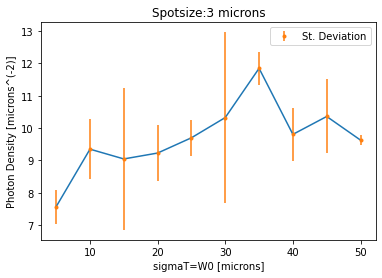

In [17]:
plt.plot(sigma,Pd_Mean[:,0])
plt.errorbar(sigma,Pd_Mean[:,0],Pd_STD[:,0], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize1} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize1}_Finite.png',dpi=200)

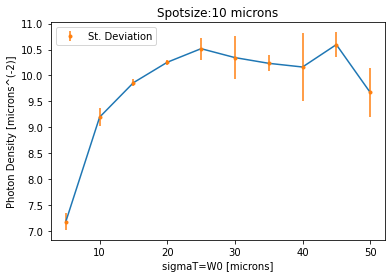

In [18]:
plt.plot(sigma,Pd_Mean[:,1])
plt.errorbar(sigma,Pd_Mean[:,1],Pd_STD[:,1], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize2} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize2}_Finite.png',dpi=200)

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# Data=np.zeros((n,3))
# Data[:,0]=sigma
# Data[:,1]=Pd[:,0]
# Data[:,2]=Pd[:,1]
# df=pd.DataFrame(Data)

# List=["Sigma","3 microns              ","10 microns"]
# df.to_csv(f'{path}\Photon_Density.txt',header=List , index=None, sep="\t", mode='w')



# print(df)

In [21]:
'''
Saving the Data
'''


import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,0,0:r]
df=pd.DataFrame(Data)

List=["SigmaT+W0","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize1}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

      0          1          2
0   5.0   8.099154   7.050671
1  10.0   8.418330  10.280329
2  15.0   6.857006  11.238923
3  20.0  10.088302   8.370797
4  25.0  10.251751   9.149924
5  30.0   7.692645  12.958213
6  35.0  11.326497  12.362707
7  40.0  10.617702   8.994571
8  45.0  11.500544   9.216193
9  50.0   9.773211   9.483771


In [25]:
import pandas as pd
import numpy as np
import os

Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,1,0:r]
df=pd.DataFrame(Data)
List=["SigmaT+W0","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

      0          1          2
0   5.0   7.015963   7.335171
1  10.0   9.363102   9.024938
2  15.0   9.923238   9.795862
3  20.0  10.205341  10.303208
4  25.0  10.303535  10.729784
5  30.0   9.928169  10.761028
6  35.0  10.388540  10.079320
7  40.0  10.828144   9.496979
8  45.0  10.834086  10.356093
9  50.0  10.145768   9.199292


In [26]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=0 , sep="\t")
p=pd.DataFrame.to_numpy(r)


            0                   1                   2
0   SigmaT+W0     Photon Density      Photon Density 
1         5.0   7.015962829375742   7.335170679679823
2        10.0    9.36310212168934   9.024937868846871
3        15.0   9.923238022859023   9.795861633769436
4        20.0  10.205341449154906  10.303207564889458
5        25.0  10.303535426571049  10.729784071169112
6        30.0   9.928169345191936  10.761027637386151
7        35.0  10.388539760461992  10.079320459710036
8        40.0  10.828143682250042   9.496978583730868
9        45.0  10.834086377049537  10.356092715131602
10       50.0  10.145767971258223   9.199292146342835
